In [2]:
import torch
import requests
from PIL import Image
from io import BytesIO
from transformers import AutoProcessor, LlavaForConditionalGeneration
import matplotlib.pyplot as plt
import time
import numpy as np

In [3]:
# Check if GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cuda


# Helper Functions

In [15]:
def load_image_from_url(url):
    """Load an image from a URL."""
    response = requests.get(url)
    return Image.open(BytesIO(response.content))

def load_image_from_path(image_path):
    """Load an image from a local path."""
    return Image.open(image_path)

def display_image(image):
    """Display an image."""
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

def process_image_with_llava(image, prompt, max_new_tokens=256):
    """Process an image with LLaVA."""
    # Make sure the prompt includes the image token
    if "<image>" not in prompt:
        prompt = "<image>\n" + prompt
    
    # Prepare inputs
    inputs = processor(prompt, image, return_tensors="pt").to(device=device, dtype=torch.float16)
    
    # Record start time
    start_time = time.time()
    
    # Generate response
    with torch.no_grad():
        output = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False  # Deterministic generation
        )
    
    # Calculate processing time
    processing_time = time.time() - start_time
    
    # Decode and return the response
    response = processor.decode(output[0], skip_special_tokens=True)
    
    # Remove the prompt from the response
    if prompt in response:
        response = response.replace(prompt, "").strip()
    
    return response, processing_time

# Load LLava Model


In [4]:
model_id = "llava-hf/llava-1.5-7b-hf"

In [7]:
print("Loading LLaVA model and processor...")
processor = AutoProcessor.from_pretrained(model_id)
model = LlavaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.float16,  # Use float16 for efficiency
    low_cpu_mem_usage=True,
    device_map="auto"
)

Loading LLaVA model and processor...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

# Basic Image Analysis with LLaVA

In [75]:
image_url = "https://preview.redd.it/my-poor-snorlax-waiting-for-his-salad-lunch-not-knowing-i-v0-4peqwuydlm0c1.jpg?auto=webp&s=577b3f03bad7d92e1576af44b4d782e08fa1996b"

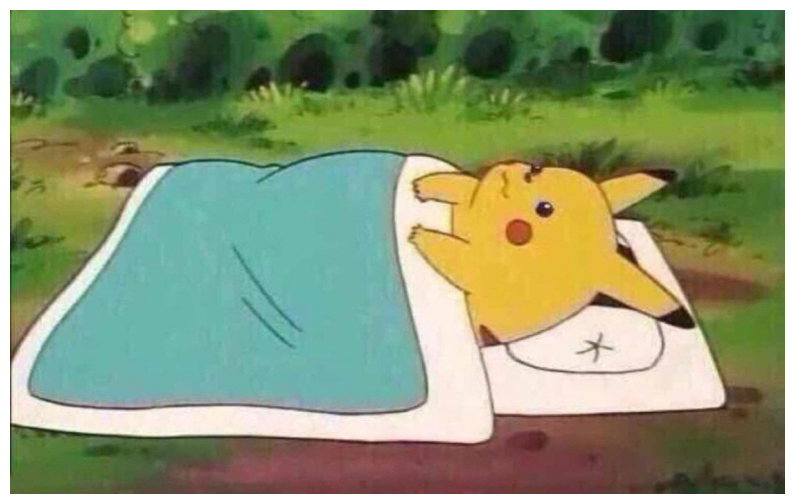

In [76]:
# Load and display the image
image = load_image_from_url(image_url)
display_image(image)

In [79]:
def ask(prompt_description):
    description, time_taken = process_image_with_llava(image, prompt_description)
    print(f"Image Description (processed in {time_taken:.2f}s):")
    print(description)


In [80]:
# Basic image description
ask("Describe this image in detail")

Image Description (processed in 2.48s):

Describe this image in detail.

The image features a cartoon character, specifically a yellow and black Pikachu, lying on a bed. The Pikachu is positioned on its side, with its head resting on a pillow. The bed is covered with a blue blanket, and the Pikachu appears to be sleeping or resting comfortably.


In [87]:
# Basic image description
ask("What kind of meme sentence should be put here?")

Image Description (processed in 0.65s):

What kind of meme sentence should be put here?
"When you're trying to sleep but still have to go to class"


## Pipeline step by step

Note that some pre-processing may be missing here (e.g.: template), thus the generation might differ!

In [88]:
import torch
import numpy as np
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from transformers import AutoProcessor, CLIPVisionModel, AutoModelForCausalLM
import time

In [89]:
model

LlavaForConditionalGeneration(
  (vision_tower): CLIPVisionModel(
    (vision_model): CLIPVisionTransformer(
      (embeddings): CLIPVisionEmbeddings(
        (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
        (position_embedding): Embedding(577, 1024)
      )
      (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-23): 24 x CLIPEncoderLayer(
            (self_attn): CLIPSdpaAttention(
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): Q

In [190]:
# Access the individual components from the model
vision_tower = model.vision_tower
language_model = model.language_model
vision_proj = model.multi_modal_projector


In [191]:
image_inputs = processor.image_processor(images=image, return_tensors="pt").to(device, torch.float16)

In [192]:
print(f"Image inputs shape: {image_inputs.pixel_values.shape}")
# This should be [1, 3, 336, 336] for LLaVA-1.5 (batch_size, channels, height, width)

Image inputs shape: torch.Size([1, 3, 336, 336])


In [193]:
with torch.no_grad():
    # If vision_tower returns a dict, we need to extract the hidden states
    vision_outputs = vision_tower(image_inputs.pixel_values)
    if hasattr(vision_outputs, "last_hidden_state"):
        image_features = vision_outputs.last_hidden_state
    else:
        # Handle the case where vision_tower might return a different structure
        image_features = vision_outputs[0]

In [194]:
with torch.no_grad():
    projected_image_features = vision_proj(image_features)

In [195]:
projected_image_features.shape

torch.Size([1, 577, 4096])

In [196]:
# Create a prompt with the special image token
prompt = "<image>What is this pokemon?"
print(f"Prompt: {prompt}")

# Tokenize the prompt
text_inputs = processor.tokenizer(
    prompt, 
    return_tensors="pt", 
    padding=True
).to(device)


Prompt: <image>What is this pokemon?


In [197]:
print(f"Tokenized prompt shape: {text_inputs.input_ids.shape}")
# Print the tokens
print("Tokens:", processor.tokenizer.convert_ids_to_tokens(text_inputs.input_ids[0]))


Tokenized prompt shape: torch.Size([1, 8])
Tokens: ['<s>', '<image>', '▁What', '▁is', '▁this', '▁pok', 'emon', '?']


In [198]:
image_token_id = processor.tokenizer.convert_tokens_to_ids("<image>")
if image_token_id == processor.tokenizer.unk_token_id:
    # If <image> is not in the vocabulary, check for the image token index from config
    image_token_id = complete_model.config.image_token_index

In [203]:
# Find positions of the image token
image_token_positions = (text_inputs.input_ids == image_token_id).nonzero()
print(f"Image token positions: {image_token_positions}")

# Get the word embeddings layer from the language model
word_embeddings = language_model.get_input_embeddings()
input_embeds = word_embeddings(text_inputs.input_ids)
print(f"Initial input embeddings shape: {input_embeds.shape}")

# Now we need to insert the visual features into the correct position
if len(image_token_positions) > 0:
    # Get the batch index and position
    batch_idx, seq_idx = image_token_positions[0]
    
    # In a real implementation, we would:
    print("1. Remove the image token")
    print("2. Insert all image features at that position")
    print("3. Adjust attention mask and position ids accordingly")
    
    print("\nLet's show this process step by step:")
    
    # 1. Extract the parts before and after the image token
    input_ids_before = text_inputs.input_ids[batch_idx, :seq_idx]
    input_ids_after = text_inputs.input_ids[batch_idx, seq_idx+1:]
    
    print(f"  - Text tokens before image: {input_ids_before.shape[0]}")
    print(f"  - Text tokens after image: {input_ids_after.shape[0]}")
    
    # 2. Create the new combined sequence
    num_image_tokens = projected_image_features.shape[1]  # Typically 576 for CLIP ViT-L/14
    print(f"  - Number of image feature tokens: {num_image_tokens}")
    
    # 3. Calculate new sequence length
    new_seq_length = input_ids_before.shape[0] + num_image_tokens + input_ids_after.shape[0]
    print(f"  - New sequence length: {new_seq_length}")
    
    # 4. Create new embeddings container
    new_input_embeds = torch.zeros(
        (1, new_seq_length, input_embeds.shape[2]), 
        dtype=input_embeds.dtype, 
        device=input_embeds.device
    )
    
    # 5. Fill with text embeddings before image
    if input_ids_before.shape[0] > 0:
        text_embeds_before = word_embeddings(input_ids_before)
        new_input_embeds[0, :input_ids_before.shape[0]] = text_embeds_before
    
    # 6. Add image embeddings
    new_input_embeds[
        0, 
        input_ids_before.shape[0]:input_ids_before.shape[0] + num_image_tokens
    ] = projected_image_features[0]
    
    # 7. Add text embeddings after image
    if input_ids_after.shape[0] > 0:
        text_embeds_after = word_embeddings(input_ids_after)
        new_input_embeds[
            0, 
            input_ids_before.shape[0] + num_image_tokens:
        ] = text_embeds_after
    
    print(f"  - Final input embeddings shape: {new_input_embeds.shape}")
    
    # 8. Update attention mask
    new_attention_mask = torch.ones(
        (1, new_seq_length), 
        dtype=text_inputs.attention_mask.dtype,
        device=text_inputs.attention_mask.device
    )

Image token positions: tensor([[0, 1]], device='cuda:0')
Initial input embeddings shape: torch.Size([1, 8, 4096])
1. Remove the image token
2. Insert all image features at that position
3. Adjust attention mask and position ids accordingly

Let's show this process step by step:
  - Text tokens before image: 1
  - Text tokens after image: 6
  - Number of image feature tokens: 577
  - New sequence length: 584
  - Final input embeddings shape: torch.Size([1, 584, 4096])


In [187]:
with torch.no_grad():
    outputs = language_model(
        inputs_embeds=new_input_embeds,
        attention_mask=new_attention_mask,
        return_dict=True
    )
    
    # Get the logits from the last position
    next_token_logits = outputs.logits[0, -1, :]
    
    # Get the most likely next token
    next_token_id = torch.argmax(next_token_logits).item()
    
    # Start our generated sequence with this token
    generated_ids = [next_token_id]
    
    # Add this token to our running sequence
    current_input_ids = torch.cat([
        text_inputs.input_ids[0], 
        torch.tensor([next_token_id], device=device)
    ])

# Step 2: Autoregressive generation loop (Greedy)
max_new_tokens = 256
for _ in range(max_new_tokens - 1):
    # Prepare inputs for the next iteration
    # Important: we need to keep the image tokens in the sequence!
    # We recreate the embeddings with the extended sequence
    
    # First get text embeddings before the image
    if seq_idx > 0:
        prefix_embeds = word_embeddings(current_input_ids[:seq_idx])
    else:
        prefix_embeds = torch.tensor([], device=device)
        
    # Then get text embeddings after the image (including generated tokens)
    if seq_idx < current_input_ids.shape[0]:
        suffix_embeds = word_embeddings(current_input_ids[seq_idx+1:])
    else:
        suffix_embeds = torch.tensor([], device=device)
    
    # Recreate the full embedding sequence
    current_embeds = torch.cat([
        prefix_embeds.view(1, -1, input_embeds.shape[-1]) if prefix_embeds.numel() > 0 else torch.zeros((1, 0, input_embeds.shape[-1]), device=device),
        projected_image_features,
        suffix_embeds.view(1, -1, input_embeds.shape[-1]) if suffix_embeds.numel() > 0 else torch.zeros((1, 0, input_embeds.shape[-1]), device=device)
    ], dim=1)
    
    # Update attention mask
    current_attention_mask = torch.ones((1, current_embeds.shape[1]), dtype=torch.long, device=device)
    
    # Forward pass
    with torch.no_grad():
        outputs = language_model(
            inputs_embeds=current_embeds,
            attention_mask=current_attention_mask,
            return_dict=True
        )
        
        # Get next token logits & apply any sampling/temperature if desired
        next_token_logits = outputs.logits[0, -1, :]
        next_token_id = torch.argmax(next_token_logits).item()
        
        # Add to generated output
        generated_ids.append(next_token_id)
        
        # Check if we've hit the end of sequence token
        if next_token_id == processor.tokenizer.eos_token_id:
            break
            
        # Update for next iteration
        current_input_ids = torch.cat([
            current_input_ids, 
            torch.tensor([next_token_id], device=device)
        ])

# Step 3: Decode the generated tokens
generated_text = processor.tokenizer.decode(generated_ids, skip_special_tokens=True)

In [188]:
generated_text

'\nPokemon: Pidgeot\nType: Normal/Flying\nHeight: 1.5m\nWeight: 20kg\nAbilities: Keen Eye, Sharp Beak\nMoves: Gust, Rock Smash, Quick Attack, Tackle\nEvolution: Pidgey -> Pidgeot\nLocation: Kanto, Johto, Hoenn, Sinnoh, Unova, Kalos, Alola, Galar\n\nPidgeot is a large bird-like Pokemon that is known for its sharp beak and keen eye. It is a Normal/Flying type, which means it is strong against ground-type Pokemon and weak against flying-type Pokemon. Pidgeot is also known for its ability to fly at high speeds and its powerful attacks, such as Gust, Rock Smash, Quick Attack, and Tackle.\n\nPidgeot is the evolved form of Pidgey, which can be caught in the wild or hatched from Pidge Eggs. Pidgeot is a popular choice among trainers due to its powerful attacks and high speed. It is also a staple in many competitive batt'